In [1]:
import os

import numpy as np
import pandas as pd
import anndata
import sklearn.decomposition as decomposition
import openTSNE

from atc_classification import ATC
import embedding_annotation as annotate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join("..", "data", "2019-04.csv"), index_col=0)
df.shape

(12739, 829)

In [3]:
adata = anndata.AnnData(df.values, dtype=np.float32)
adata.obs_names = df.index.values
adata.var_names = df.columns.values
adata

AnnData object with n_obs × n_vars = 12739 × 829

In [4]:
levels = {
    1: slice(0, 1),
    2: slice(0, 3),
    3: slice(0, 4),
    4: slice(0, 5),
    5: slice(0, 7),
}
for l in levels:
    tmp = df.T

    tmp["group"] = tmp.index.str[levels[l]]
    tmp = tmp.groupby("group").sum()
    tmp = tmp.T
    tmp = tmp.loc[:, tmp.columns.str.len() == (levels[l].stop - levels[l].start)]

    adata.obsm[f"ATC_{l}"] = tmp

In [5]:
adata

AnnData object with n_obs × n_vars = 12739 × 829
    obsm: 'ATC_1', 'ATC_2', 'ATC_3', 'ATC_4', 'ATC_5'

### Filter out doctors with too few drug prescriptions

In [6]:
min_count = 25

adata.obs["prescription_count"] = adata.X.sum(axis=1)
adata = adata[adata.obs["prescription_count"] > min_count]

In [7]:
adata

View of AnnData object with n_obs × n_vars = 3925 × 829
    obs: 'prescription_count'
    obsm: 'ATC_1', 'ATC_2', 'ATC_3', 'ATC_4', 'ATC_5'

### Generate t-SNE embedding

In [8]:
pca = decomposition.PCA(n_components=50)
adata.obsm["X_pca"] = pca.fit_transform(adata.obsm["ATC_4"])

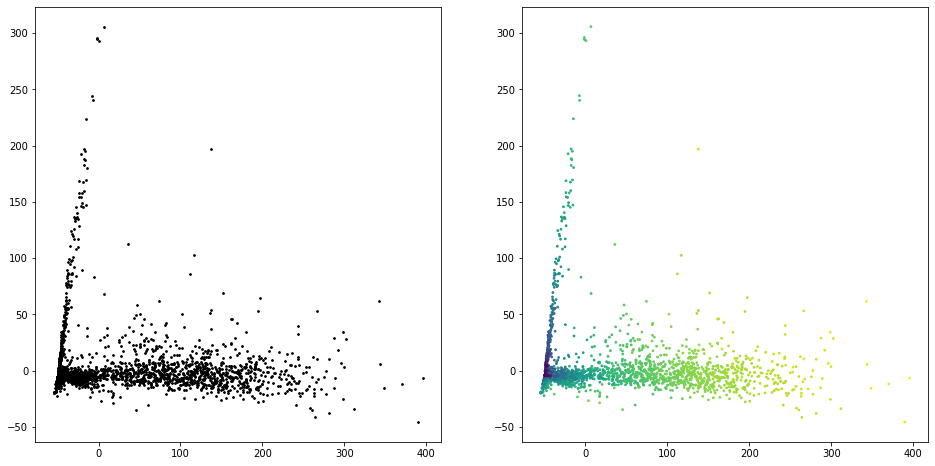

In [9]:
z = adata.obsm["X_pca"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(z[:, 0], z[:, 1], s=3, c="k")
ax[1].scatter(z[:, 0], z[:, 1], s=3, c=np.log(adata.obs["prescription_count"]))

In [10]:
adata.obsm["X_tsne"] = openTSNE.TSNE(
    metric="cosine", perplexity=50, exaggeration=1.5, dof=0.8, n_jobs=4
).fit(adata.obsm["X_pca"])

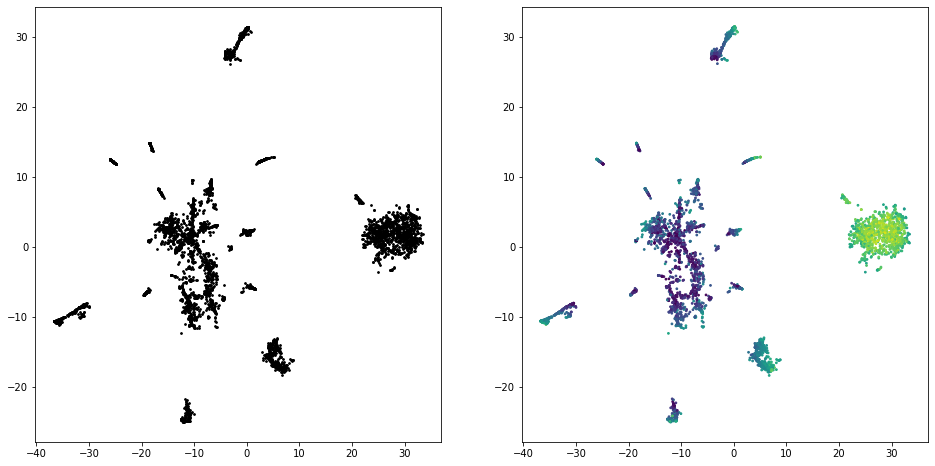

In [11]:
z = adata.obsm["X_tsne"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(z[:, 0], z[:, 1], s=3, c="k")
ax[1].scatter(z[:, 0], z[:, 1], s=3, c=np.log(adata.obs["prescription_count"]))

# Annotation pipeline

In [12]:
features = pd.concat([
    adata.obsm["ATC_1"],
    adata.obsm["ATC_2"],
    adata.obsm["ATC_3"],
], axis=1)
features.shape

(3925, 277)

In [13]:
features

group,A,B,C,D,G,H,J,L,M,N,...,S01E,S01F,S01G,S01X,S03B,V01A,V03A,V06C,V06D,V07A
predpis_zdravnik,,,,,,,,,,,,,,,,,,,,,
0003CF5DF9C3D932F1A64EBF288F253205254CA4,10,3,10,0,0,0,3,0,0,36,...,0,0,0,0,0,0,0,0,0,0
0009F6E1D43884A3F4E7962BFB6CA3B93D398778,3,2,0,0,0,0,20,0,23,11,...,0,0,0,0,0,0,0,0,8,0
000DE52368D858D96734054B9F863E25E661758E,16,3,0,32,1,5,44,0,16,30,...,0,0,4,0,0,0,0,2,0,0
000DE6DB7F96F91E0893D0880E6458A822C9B0E6,46,21,52,12,8,4,11,1,14,136,...,2,0,0,2,0,0,0,0,2,0
000DFC4C5193052A7136995A29CE0F917285781C,5,0,6,4,5,0,40,0,25,47,...,0,0,5,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FF7D37EC680E5E75BE7230B84B0EB42810909F89,45,10,20,40,5,16,67,0,28,81,...,0,0,7,0,0,0,0,0,1,0
FF843C551CBF57E4C0758F0695476D96DA9A20A4,122,46,256,25,15,43,32,5,50,154,...,3,0,5,7,0,0,0,0,16,0
FF96506331DF4FFCF40F33C860FE23A5FE644F12,0,0,2,0,0,0,0,0,0,28,...,0,0,0,0,0,0,0,0,0,0


In [14]:
candidates = annotate.fs.morans_i(adata.obsm["X_tsne"], features)
candidates

,feature,morans_i,pvalue,fdr
0,A,0.740208,0.0,0.0
1,B,0.717938,0.0,0.0
2,C,0.848183,0.0,0.0
3,D,0.661811,0.0,0.0
4,G,0.845585,0.0,0.0
...,...,...,...,...
269,S01G,0.500364,0.0,0.0
270,S01X,0.498971,0.0,0.0
272,V01A,0.101548,0.0,0.0
273,V03A,0.191346,0.0,0.0


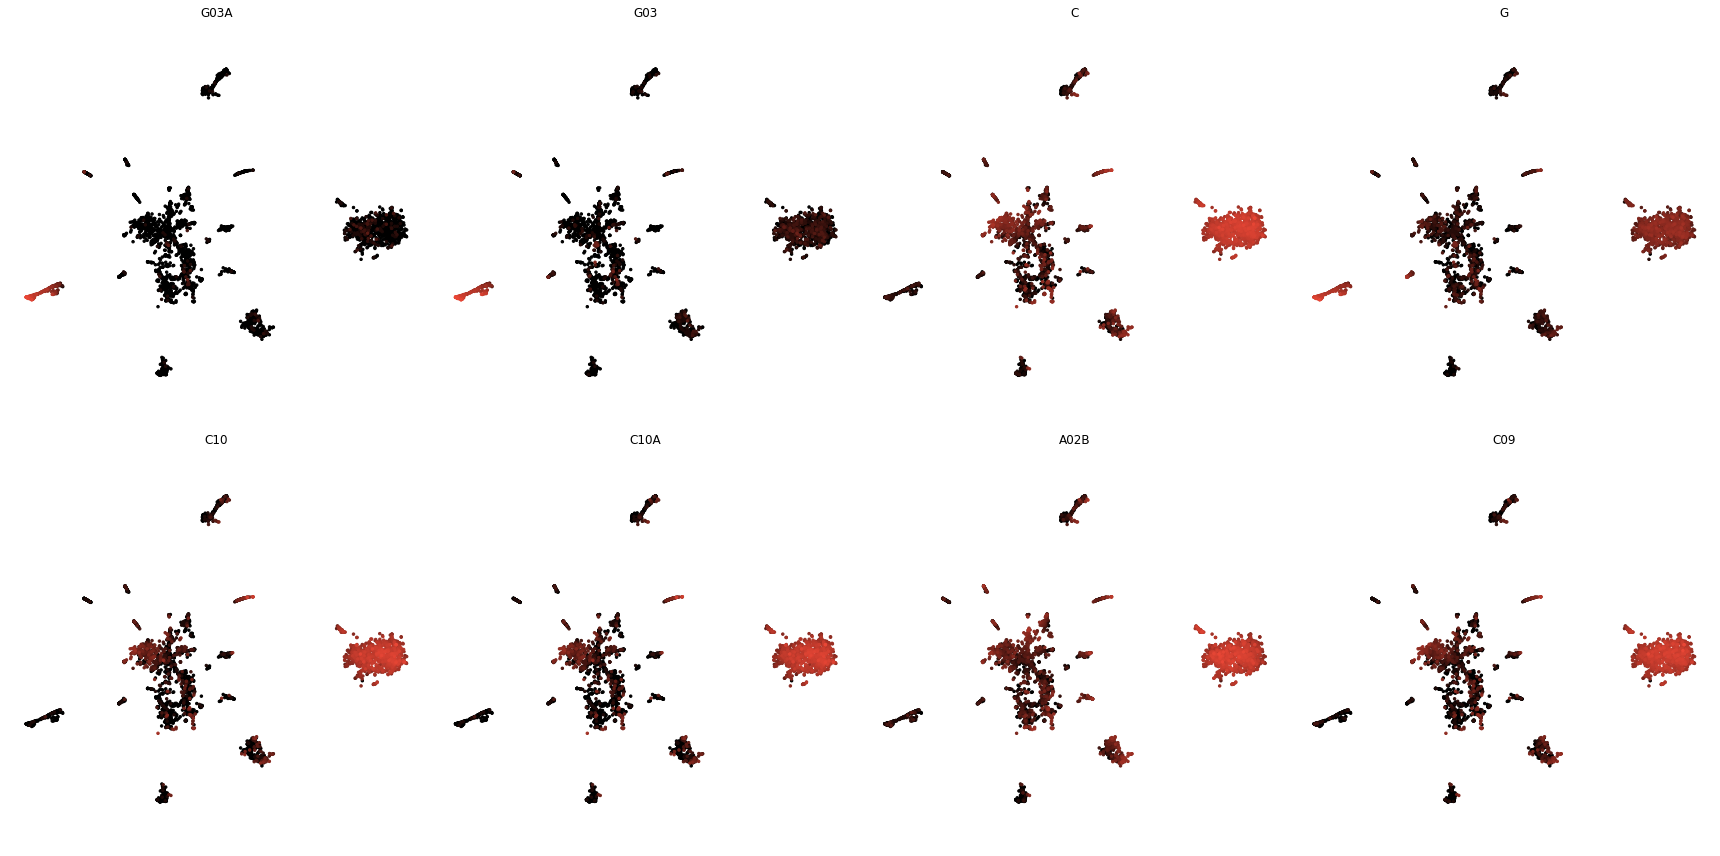

In [15]:
annotate.pl.plot_features(
    candidates.sort_values("morans_i", ascending=False)["feature"].tolist()[:8],
    features,
    adata.obsm["X_tsne"],
    s=6,
    alpha=1,
    log=True,
)

In [16]:
grid, feature_densities = annotate.an.estimate_feature_densities(
    candidates["feature"].tolist(),
    adata.obsm["X_tsne"],
    features,
    log=True,
)

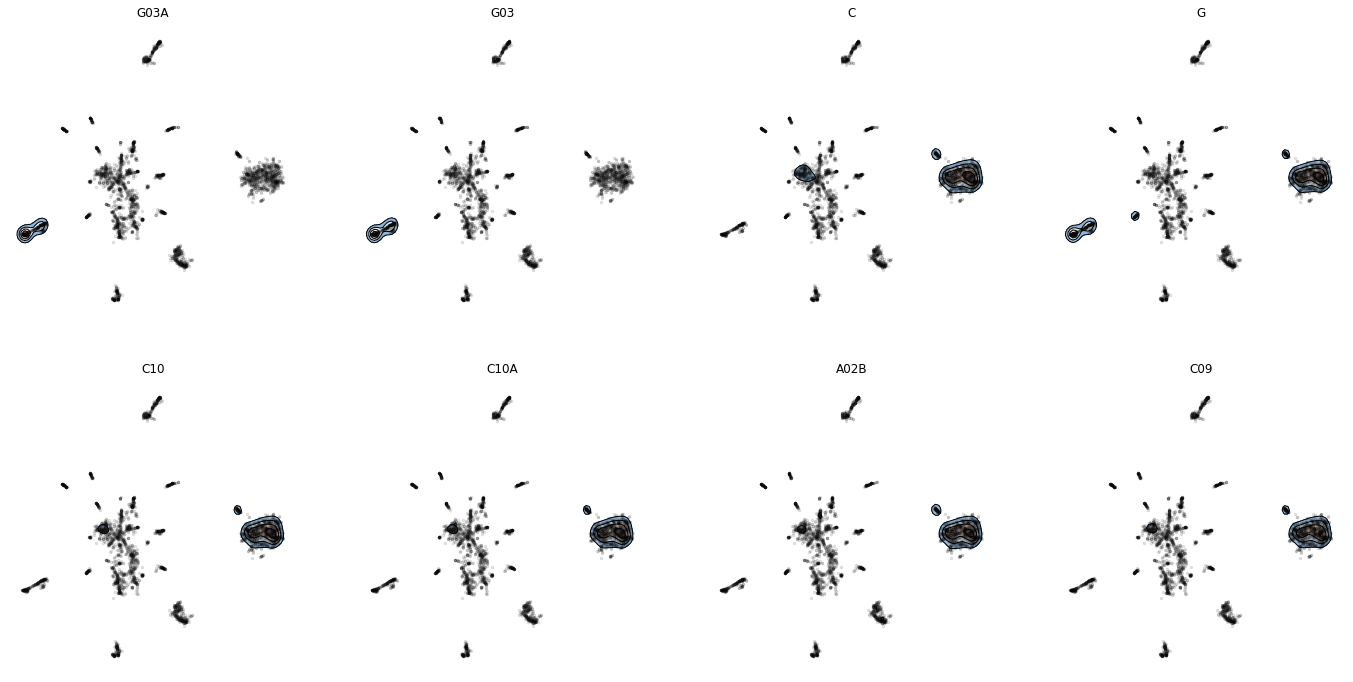

In [17]:
annotate.pl.plot_feature_densities(
    candidates.sort_values("morans_i", ascending=False)["feature"].tolist()[:8],
    grid,
    feature_densities,
    embedding=adata.obsm["X_tsne"],
)

In [65]:
from scipy.spatial.distance import pdist, squareform
import functools

def abs_(f):
    @functools.wraps(f)
    def _f(*args, **kwargs):
        return np.abs(f(*args, **kwargs))

    return _f

overlap = pdist(feature_densities.values, metric=abs_(annotate.an.overlap_index))
overlap

array([0.85993062, 0.83610131, 0.78537458, ..., 0.09602136, 0.15074874,
       0.62676879])

In [295]:
from importlib import reload
reload(annotate.g)
reload(annotate.an)

<module 'embedding_annotation.annotate' from '/Users/pavlin/Dev/embedding_annotation/embedding_annotation/annotate.py'>

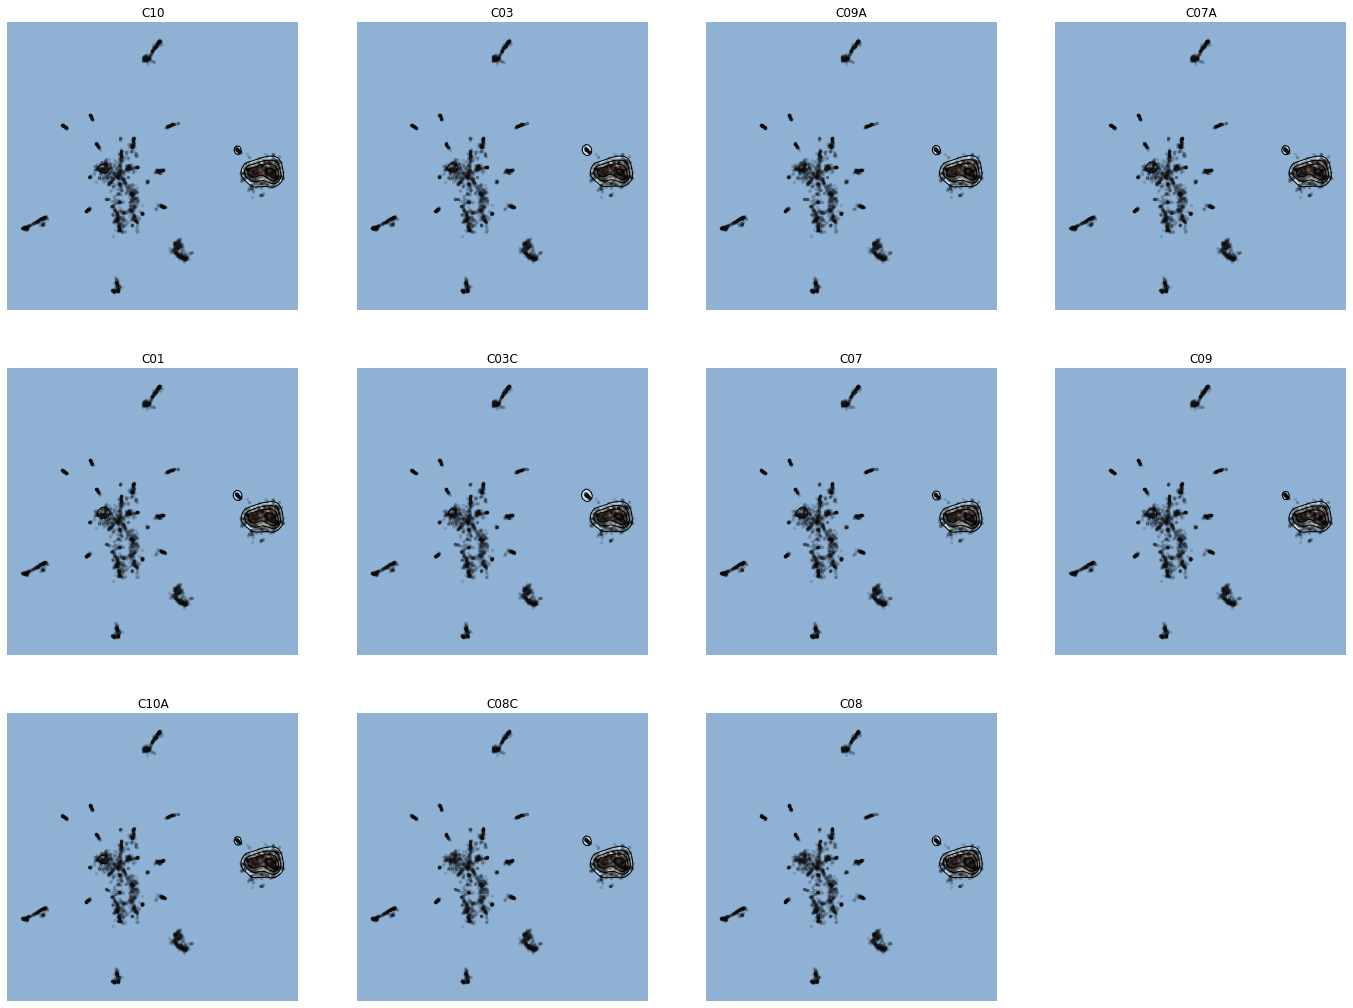

In [257]:
annotate.pl.plot_feature_densities(
    connected_components[1],
    grid,
    feature_densities,
    embedding=adata.obsm["X_tsne"],
    levels=4,
    skip_first=False,
    per_row=4,
)

In [481]:
from importlib import reload
reload(annotate.g)
reload(annotate.an)

<module 'embedding_annotation.annotate' from '/Users/pavlin/Dev/embedding_annotation/embedding_annotation/annotate.py'>

In [502]:
%%time
clusters, cluster_densities = annotate.an.group_similar_features_dendrogram(
    candidates["feature"].tolist(),
    feature_densities,
    #overlap_threshold=0.95,
)
len(clusters)

CPU times: user 4.48 s, sys: 42.3 ms, total: 4.52 s
Wall time: 4.53 s


23

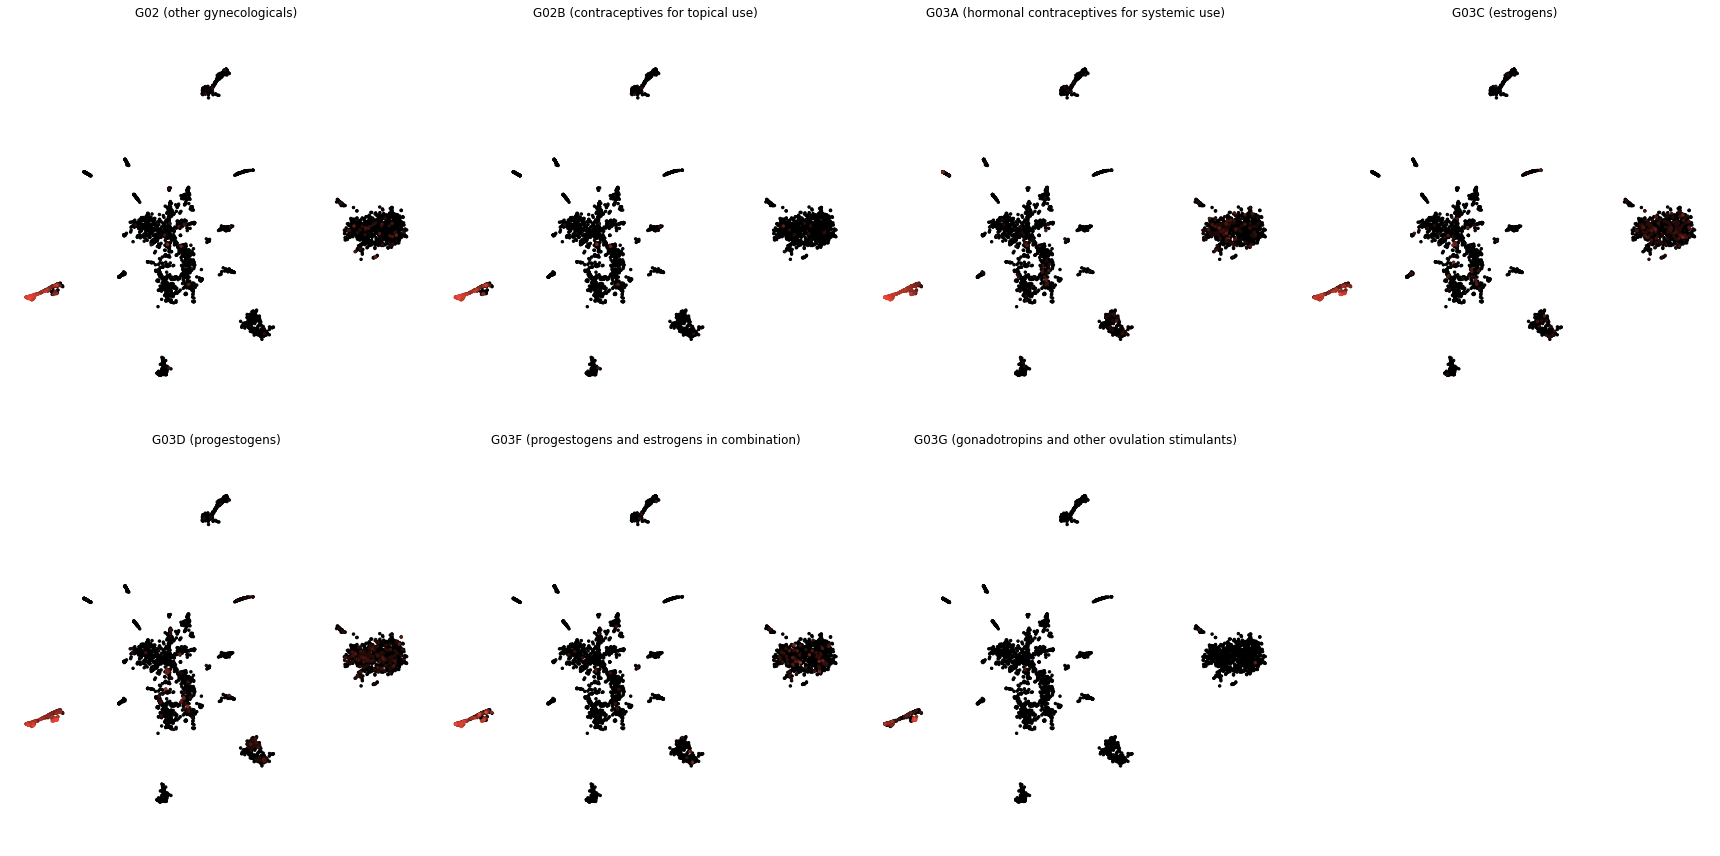

In [503]:
fig, ax = annotate.pl.plot_features(
    clusters["Cluster 1"],
    features,
    adata.obsm["X_tsne"],
    s=6,
    alpha=1,
    log=True,
    return_ax=True,
)
for ax_ in ax:
    code = ax_.get_title()
    if code in ATC:
        ax_.set_title(str(ATC[code]))

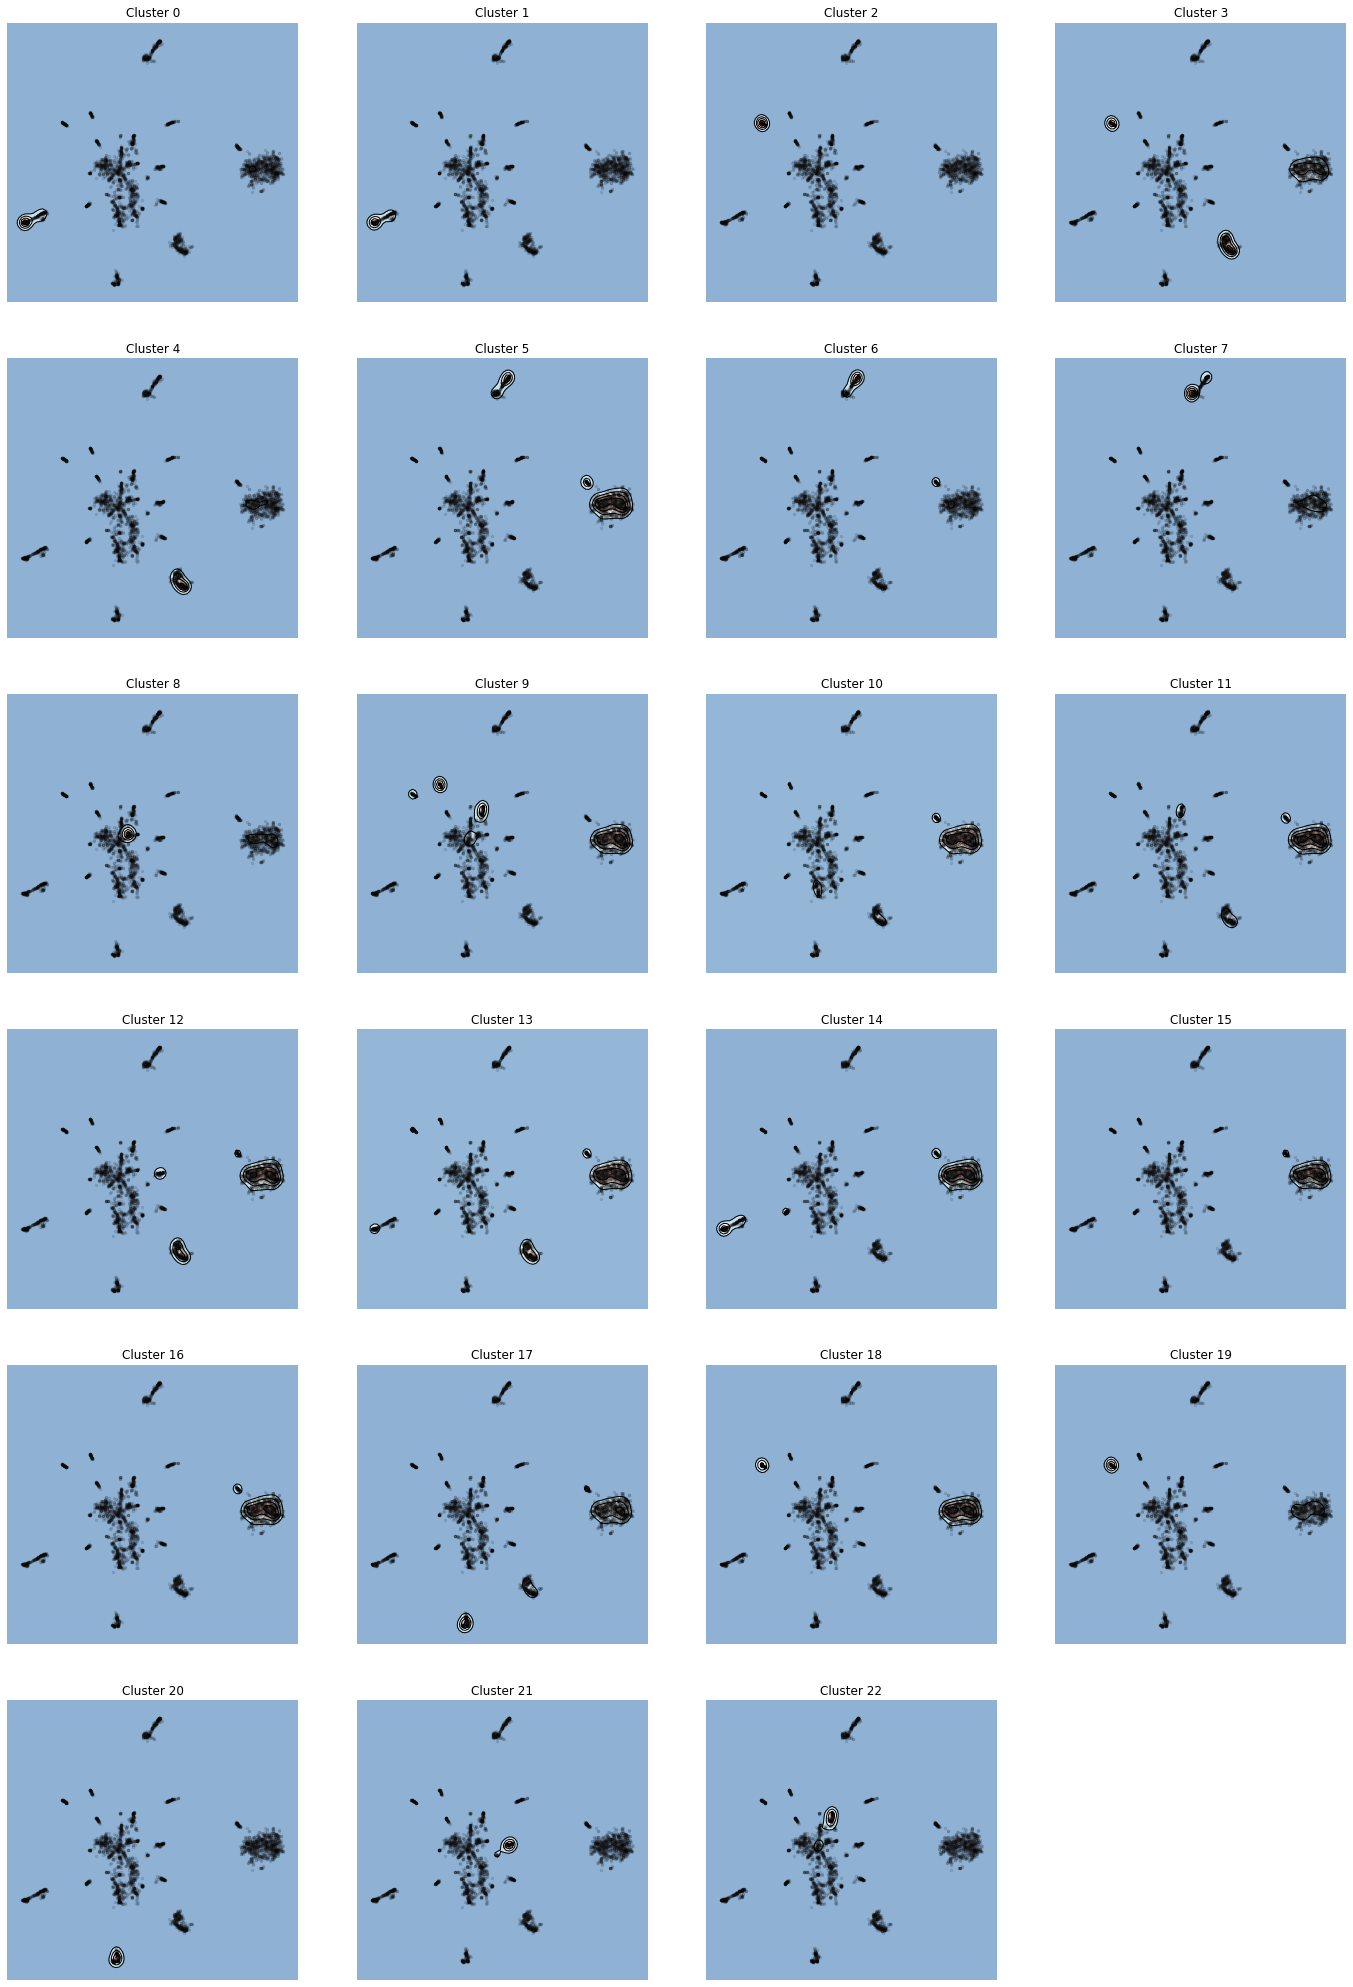

In [504]:
annotate.pl.plot_feature_densities(
    list(clusters),
    grid,
    cluster_densities,
    embedding=adata.obsm["X_tsne"],
    levels=4,
    skip_first=False,
    per_row=4,
)

In [505]:
distances = pdist(cluster_densities.values, metric=annotate.an.overlap_index)
graph = annotate.g.distances_to_graph(distances, threshold=0.5)
node_labels = dict(enumerate(cluster_densities.index.values))
graph = annotate.g.label_nodes(graph, node_labels)

In [506]:
connected_components = annotate.g.connected_components(graph)
len(connected_components)

4

In [507]:
independent_sets = annotate.g.independent_sets(graph)
np.array(independent_sets[:3])

array([['Cluster 7', 'Cluster 8', 'Cluster 20', 'Cluster 21',
        'Cluster 22', 'Cluster 4', 'Cluster 0', 'Cluster 2'],
       ['Cluster 7', 'Cluster 20', 'Cluster 21', 'Cluster 22',
        'Cluster 9', 'Cluster 0', 'Cluster 4', 'Cluster 2'],
       ['Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 4',
        'Cluster 0', 'Cluster 9', 'Cluster 6', 'Cluster 2']], dtype='<U10')

In [508]:
len(independent_sets)

32

In [509]:
np.random.shuffle(independent_sets)

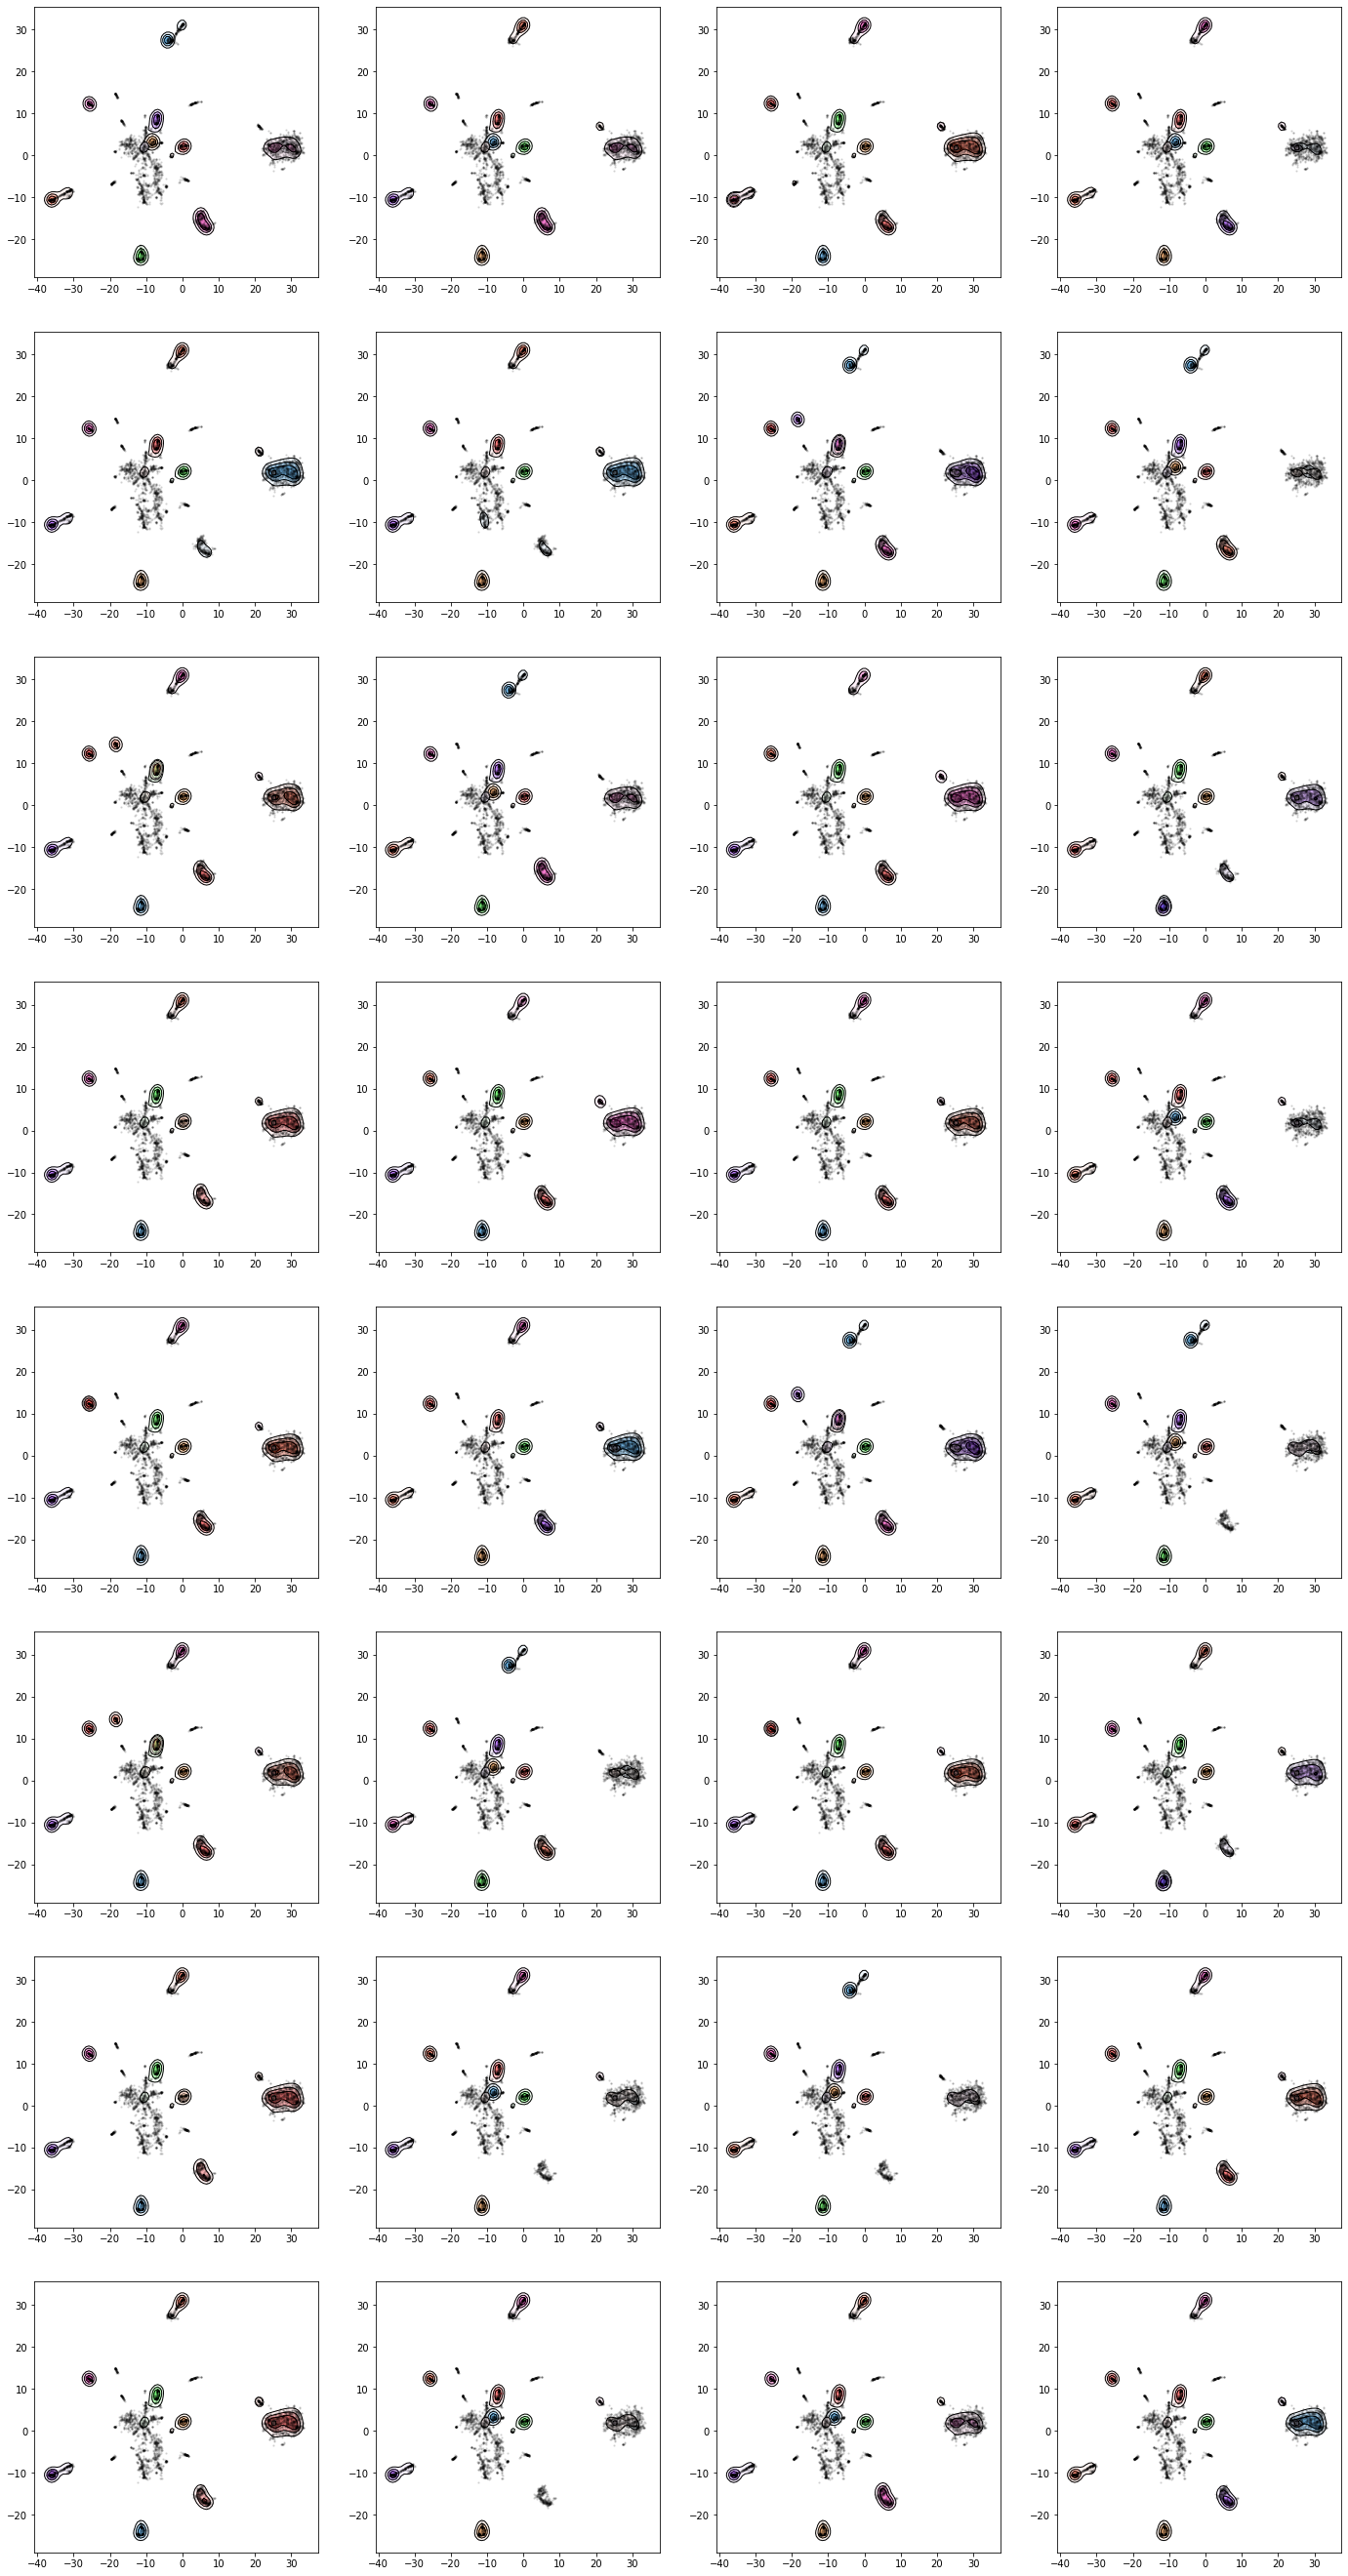

In [510]:
max_plots = 40
items = independent_sets
per_line = 4
plot_width = 24

items = items[:max_plots]
num_lines = min(int(np.ceil(len(items) / per_line)), int(np.ceil(max_plots / per_line)))

fig, ax = plt.subplots(nrows=num_lines, ncols=per_line, figsize=(plot_width, plot_width / per_line * num_lines))
for ax_, item in zip(ax.ravel(), items):
    ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])
    for clust_id in item:
        ann_map = ann_map.add(clust_id, cluster_densities.loc[clust_id].values)
    ann_map.plot_annotation(ax=ax_, scatter_kwargs=dict(s=2))

In [22]:
from importlib import reload
reload(annotate)
reload(annotate.feature_selection)
reload(annotate.annotate)
reload(annotate.plotting)

<module 'embedding_annotation.plotting' from '/Users/pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py'>

<AxesSubplot:>

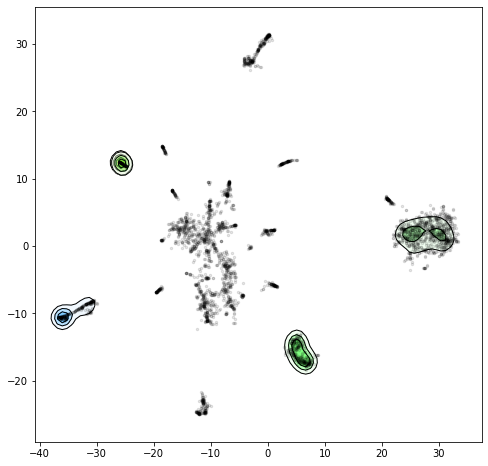

In [23]:
ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])
ann_map = ann_map.add("Cluster 0", cluster_densities.iloc[0].values)
ann_map = ann_map.add("Cluster 2", cluster_densities.iloc[2].values)
ann_map = ann_map.add("Cluster 3", cluster_densities.iloc[3].values)
ann_map.plot_annotation()

In [24]:
ann_map.rank_overlap_densities(cluster_densities).sort_values("score").head()

,feature,score
21,Cluster 21,0.343843
20,Cluster 20,0.482252
22,Cluster 22,0.745812
1,Cluster 1,0.918156
6,Cluster 6,0.979556


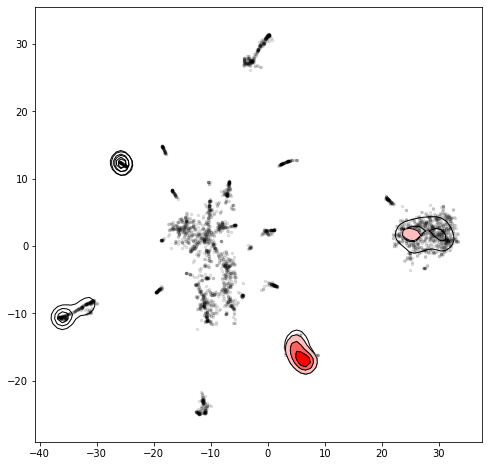

In [25]:
ann_map.plot_overlap_with(cluster_densities.loc["Cluster 4"].values)

<AxesSubplot:>

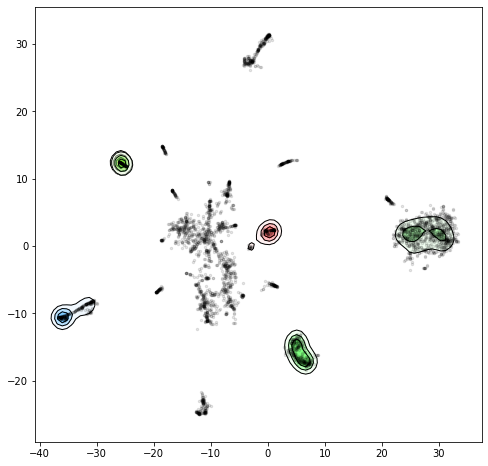

In [26]:
ann_map = ann_map.add("Cluster 21", cluster_densities.iloc[21].values)
ann_map.plot_annotation()

In [27]:
from scipy.interpolate import interp2d, griddata

In [28]:
# Estimate the likelihood of the points using the current 
z0 = griddata(grid, cluster_densities.loc["Cluster 3"], adata.obsm["X_tsne"].view(np.ndarray))

ll = -np.mean(np.log(z0))
ll

7.796384083847545

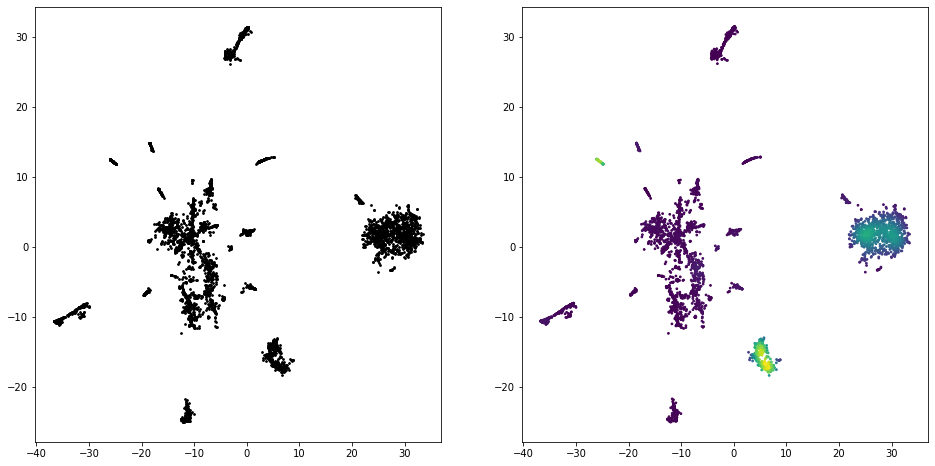

In [29]:
z = adata.obsm["X_tsne"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(z[:, 0], z[:, 1], s=3, c="k")
ax[1].scatter(z[:, 0], z[:, 1], c=z0, s=3)

In [30]:
from importlib import reload
reload(annotate)
reload(annotate.feature_selection)
reload(annotate.annotate)
reload(annotate.plotting)

<module 'embedding_annotation.plotting' from '/Users/pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py'>

In [31]:
t = np.array([0.1, 0.2, 0.3])
t /= t.sum()
t
-np.sum(t * np.log(t))

1.0114042647073518

In [32]:
grid

array([[-40.7951586 , -29.05434968],
       [-40.7951586 , -28.40198663],
       [-40.7951586 , -27.74962357],
       ...,
       [ 37.49801974,  34.22486698],
       [ 37.49801974,  34.87723004],
       [ 37.49801974,  35.5295931 ]])

Cluster 10 -6.958404345985085
Cluster 20 -6.93082842226435


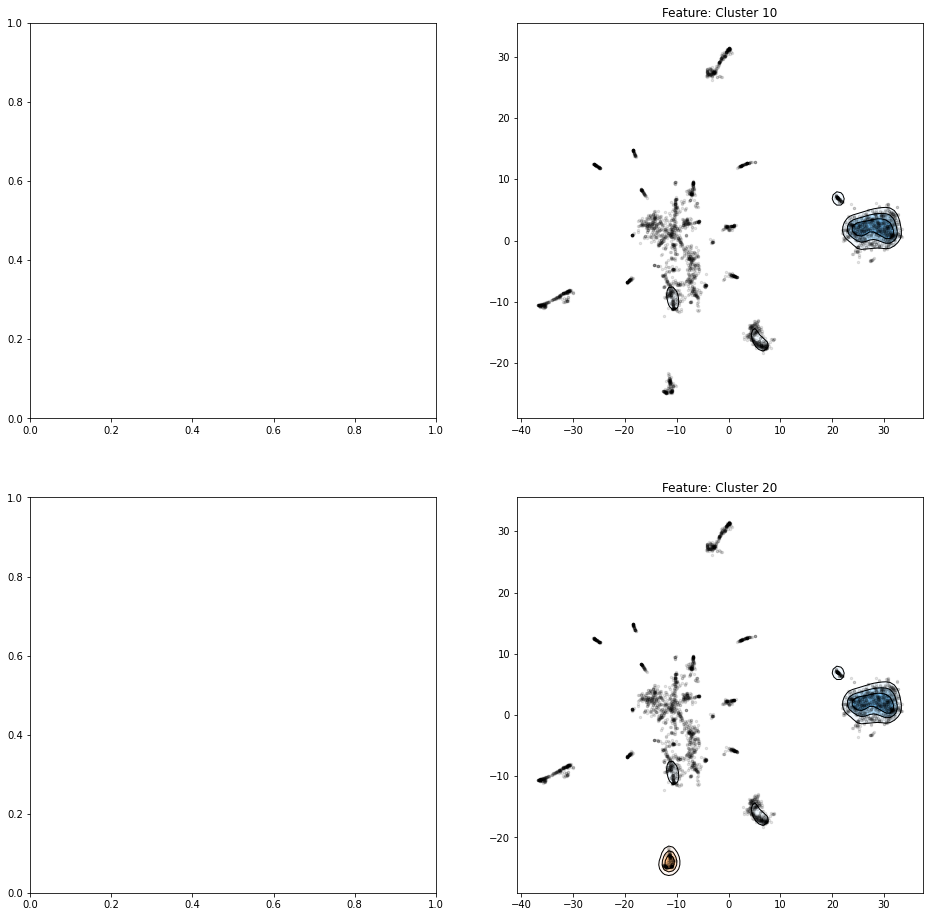

In [33]:
ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])

nrows = 2
fig, ax = plt.subplots(figsize=(16, nrows * 8), nrows=nrows, ncols=2)

for i in range(nrows):

    best_candidate = None
    best_ll = -np.inf
    for name, candidate_density in cluster_densities.iterrows():
        if name in ann_map:
            continue
        ann_map = ann_map.add(name, candidate_density)
        z0 = griddata(grid, ann_map.joint_density, adata.obsm["X_tsne"].view(np.ndarray))
        ll = np.mean(np.log(z0))
        ann_map = ann_map.remove(name)

        if ll > best_ll:
            best_ll, best_candidate = ll, name

    ann_map = ann_map.add(best_candidate, cluster_densities.loc[best_candidate].values)
    print(best_candidate, best_ll)
    
    ann_map.plot_annotation(ax=ax[i, 1])
    ax[i, 1].set_title(f"Feature: {best_candidate}")

Cluster 10 -6.958404345985085
Cluster 20 -6.93082842226435


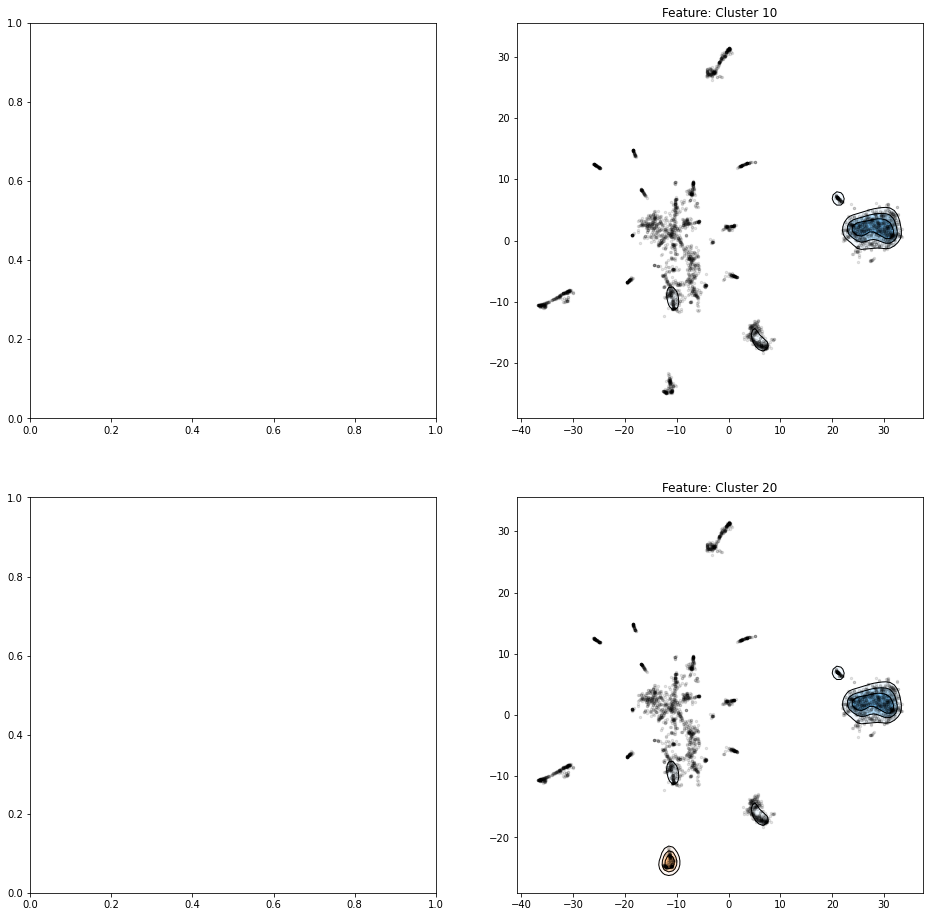

In [34]:
ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])

nrows = 2
fig, ax = plt.subplots(figsize=(16, nrows * 8), nrows=nrows, ncols=2)

for i in range(nrows):

    best_candidate = None
    best_ll = -np.inf
    for name, candidate_density in cluster_densities.iterrows():
        if name in ann_map:
            continue
        ann_map = ann_map.add(name, candidate_density)
        z0 = griddata(grid, ann_map.joint_density, adata.obsm["X_tsne"].view(np.ndarray))
        ll = np.mean(np.log(z0))
        ann_map = ann_map.remove(name)

        if ll > best_ll:
            best_ll, best_candidate = ll, name

    ann_map = ann_map.add(best_candidate, cluster_densities.loc[best_candidate].values)
    print(best_candidate, best_ll)
    
    ann_map.plot_annotation(ax=ax[i, 1])
    ax[i, 1].set_title(f"Feature: {best_candidate}")

In [35]:
from scipy.special import softmax

ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])
ann_map = ann_map.add("Cluster 0", cluster_densities.iloc[0].values)
ann_map = ann_map.add("Cluster 2", cluster_densities.iloc[2].values)
ann_map = ann_map.add("Cluster 3", cluster_densities.iloc[3].values)
ann_map = ann_map.add("Cluster 12", cluster_densities.iloc[12].values)
ann_map = ann_map.add("Cluster 21", cluster_densities.iloc[21].values)
#ann_map = ann_map.add("Cluster 11", cluster_densities.iloc[11].values)
#ann_map.plot_annotation()

#adata.obsm["X_tsne"]
#
#z0 = griddata(grid, cluster_densities.loc["Cluster 3"], adata.obsm["X_tsne"].view(np.ndarray))

i = 0
p = adata.obsm["X_tsne"][i].view(np.ndarray)

soft_assignment = []
for name, d in ann_map.scaled_densities.items():
    z0 = griddata(grid, d, adata.obsm["X_tsne"].view(np.ndarray))
    soft_assignment.append(z0)
soft_assignment = np.vstack(soft_assignment).T
    
base_p = 1 / soft_assignment.shape[1]
base_h = -soft_assignment.shape[1] * base_p * np.log(base_p)

soft_assignment = np.maximum(soft_assignment, 0.1)  # add a "compete-threshold"
soft_assignment = soft_assignment / soft_assignment.sum(axis=1, keepdims=True)
soft_assignment

array([[0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.05544555, 0.05544555, 0.46105635, 0.37260699, 0.05544555],
       ...,
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.06470463, 0.06470463, 0.06470463, 0.27258957, 0.53329653]])

In [36]:
h = -np.sum(soft_assignment * np.log(soft_assignment), axis=1)
h /= np.log(soft_assignment.shape[1])
#h /= soft_assignment.shape[1]
h

array([1.        , 1.        , 0.74928   , ..., 1.        , 1.        ,
       0.75868045])

In [37]:
np.mean(h - base_h)

-0.6907953435355194

In [38]:
h.mean()

0.9186425688985805

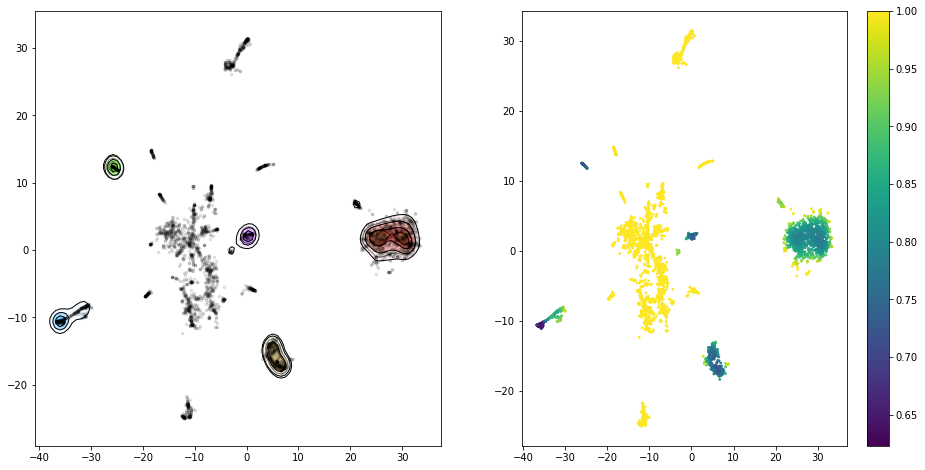

In [39]:
z = adata.obsm["X_tsne"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ann_map.plot_annotation(ax=ax[0])
sc = ax[1].scatter(z[:, 0], z[:, 1], c=h, s=3)
plt.colorbar(sc)